## Compare Step-Index computations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.speckle import GrinSpeckle, StepIndexSpeckle
from mmfsim.coupling import StepIndexFiberCoupler, StepIndexFiberDegenCoupler
from mmfsim.transforms import fresnel_transform, fourier_transform

### Input variables

In [41]:
fiber_radius = 52.5e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 2.2 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.467, n2=1.455)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [42]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

C:\Users\saucourt\Coding\MMF_LP_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))
C:\Users\saucourt\Coding\MMF_LP_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


StepIndexFiber instance with:
  - Radius: 52.5 um
  - Core index: 1.467
  - Cladding index: 1.455
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.187
  - Number of guided LP modes: 432
  - Number of guided LP modes (counting degenerates): 845
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46698018  0.          0.          1.        ]
 [ 1.46694969  2.          1.          1.        ]
 [ 1.46690962  4.          2.          1.        ]
 [ 1.46689558  1.          0.          2.        ]
 [ 1.4668605   6.          3.          1.        ]
 [ 1.46683133  3.          1.          2.        ]
 [ 1.46680267  8.          4.          1.        ]
 [ 1.46675721  5.          2.          2.        ]
 [ 1.46674337  2.          0.          3.        ]
 [ 1.46673633 10.          5.          1.        ]]


In [43]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

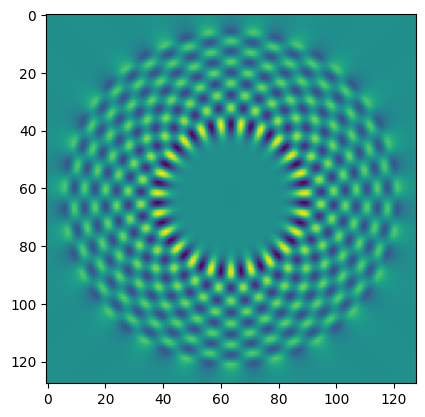

In [44]:
plt.imshow(fiber._modes[:,:,1,-1]) # Display the last guided mode found that has a refractive index above the cladding index

### Define an excitation beam with a linear phase

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Beam intensity'}, xlabel='x [um]', ylabel='y [um]'>,
        <Axes: title={'center': 'Beam phase'}, xlabel='x [um]', ylabel='y [um]'>],
       dtype=object),
  <matplotlib.image.AxesImage at 0x1501d3ea3a0>])

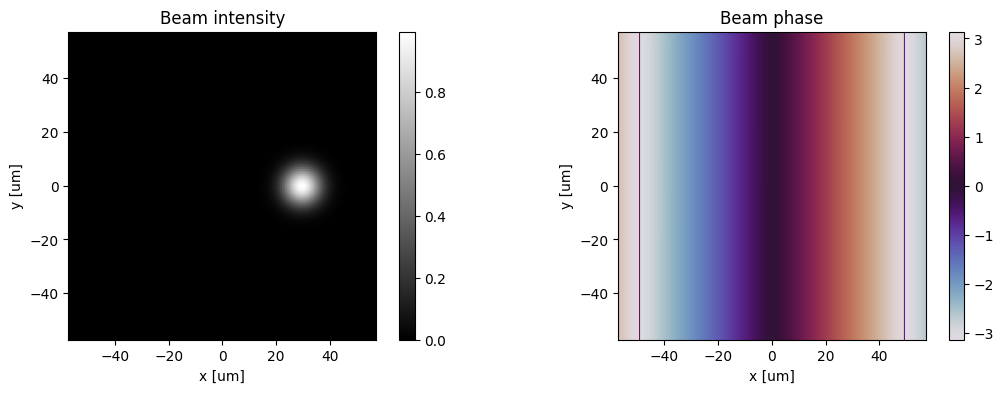

In [119]:
phase = LinearPhase(grid)
phase.compute(coeffs=[1e-4,1])

beam = GaussianBeam(grid)
#beam.compute(amplitude=1, width=10e-6, centers=[30e-6,0])
beam.compute(amplitude=1, width=10e-6, centers=[30e-6,0])
beam.add_phase(phase.phase)
beam.plot(complex=True)

### Couple that beam into the fiber

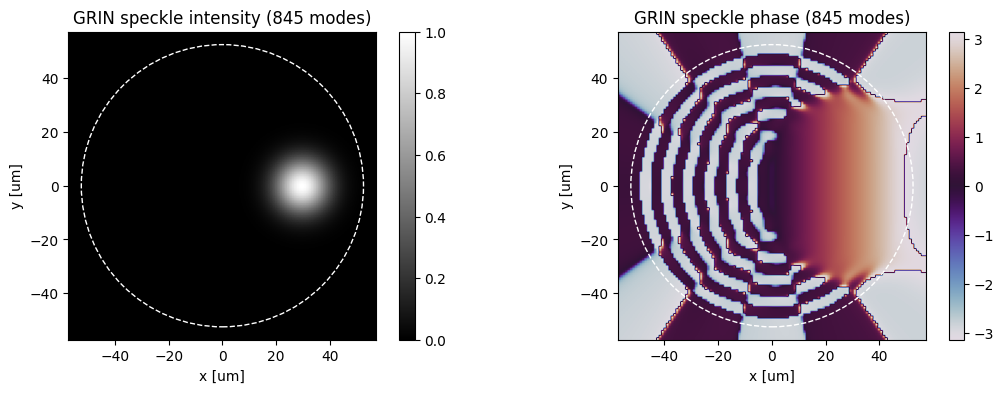

In [120]:
#coupled_in = StepIndexFiberDegenCoupler(beam.field, grid, fiber, N_modes=fiber._N_modes_degen)
#_ = coupled_in.plot(cmap='gray', complex=True)

coupled_in = StepIndexFiberDegenCoupler(beam.field, grid, fiber, N_modes=fiber._N_modes_degen)
_ = coupled_in.plot(cmap='gray', complex=True)

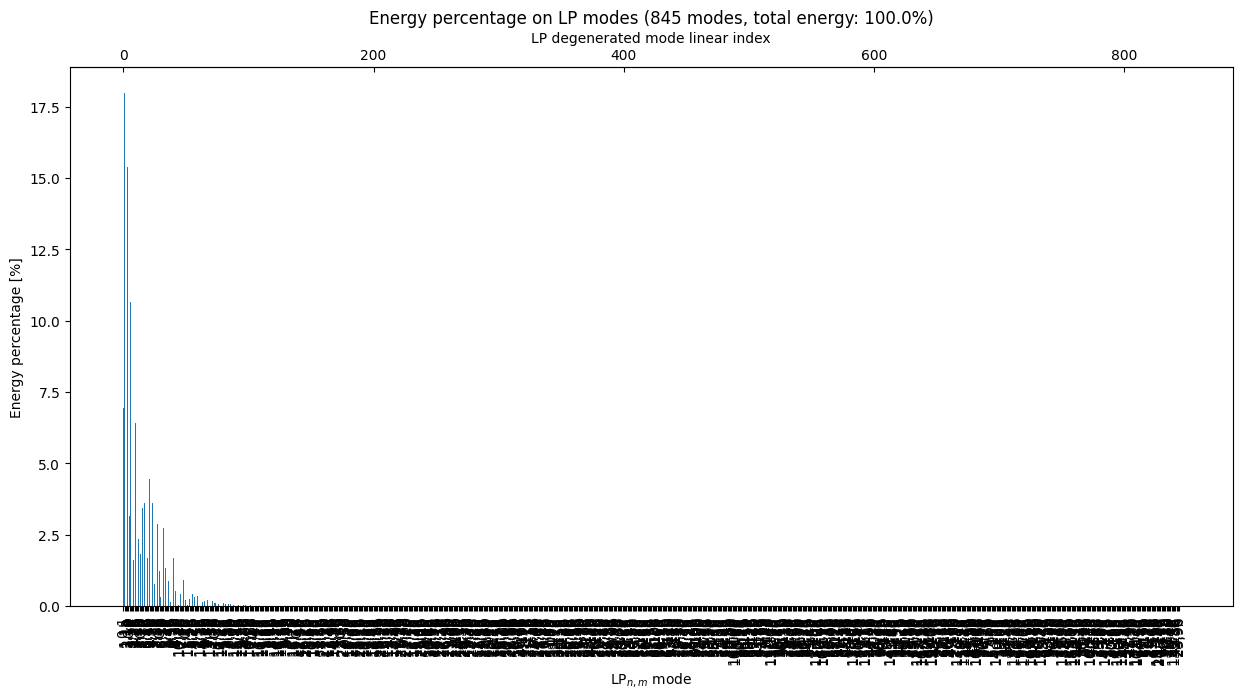

In [121]:
_ = coupled_in.plot_coefficients()




In [104]:
print(coupled_in.modes_coeffs.shape)


(845,)


In [122]:
prop_constants = fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
print(prop_constants.shape)


n1=1.467
n2=1.455
degen_constants = np.nan * np.zeros(shape=(fiber._N_modes_degen, 8))
k = 0
for i in range(fiber._N_modes):
    if prop_constants[i, 2] == 0: # Mode is centro-symmetric
        degen_constants[k, :6] = prop_constants[i, :6]
        degen_constants[k, 6] = np.square(np.abs(coupled_in.modes_coeffs[k]))
        degen_constants[k, 7] = (np.square(degen_constants[k, 1]) - np.square(n2)) / np.square(fiber._NA)
        k += 1
    else: # Mode is not centro-symmetric
        degen_constants[k, :6] = prop_constants[i, :6]
        degen_constants[k, 6] = np.square(np.abs(coupled_in.modes_coeffs[k]))
        degen_constants[k, 7] = (np.square(degen_constants[k, 1]) - np.square(n2)) / np.square(fiber._NA)
        degen_constants[k+1, :6] = prop_constants[i, :6]
        degen_constants[k+1, 6] = np.square(np.abs(coupled_in.modes_coeffs[k+1]))
        degen_constants[k+1, 7] = (np.square(degen_constants[k+1, 1]) - np.square(n2)) / np.square(fiber._NA)
        k += 2
        

(432, 6)


In [123]:
degen_constants

array([[8.66288376e+06, 1.46698018e+00, 0.00000000e+00, ...,
        5.80053259e+01, 6.94745854e-02, 9.98341666e-01],
       [8.66270368e+06, 1.46694969e+00, 1.00000000e+00, ...,
        5.79311500e+01, 1.79986328e-01, 9.95789986e-01],
       [8.66270368e+06, 1.46694969e+00, 1.00000000e+00, ...,
        5.79311500e+01, 1.95236067e-11, 9.95789986e-01],
       ...,
       [8.59281775e+06, 1.45511514e+00, 4.20000000e+01, ...,
        5.67506646e+00, 0.00000000e+00, 9.55620282e-03],
       [8.59270680e+06, 1.45509636e+00, 2.30000000e+01, ...,
        5.19145231e+00, 0.00000000e+00, 7.99689130e-03],
       [8.59270680e+06, 1.45509636e+00, 2.30000000e+01, ...,
        5.19145231e+00, 0.00000000e+00, 7.99689130e-03]])

In [124]:
print(coupled_in.modes_coeffs[1:10])
print(np.sum(np.square(np.abs(coupled_in.modes_coeffs))))

[-1.11053795e-01+4.0945497e-01j  4.36175424e-06+7.0619080e-07j
 -1.32074058e-01+3.6951205e-01j  7.94162315e-06+1.9345080e-06j
  1.02775924e-01-1.4425686e-01j -1.33929193e-01+2.9772890e-01j
  9.68779932e-06+3.1930056e-06j -1.27360985e-01+1.3288982e-03j
  1.51917163e-07+1.3178125e-06j]
0.9999973


### Define a propagation matrix with no mode coupling

First I need to concatenate $\beta$ for non-centro-symmetric modes

(432, 6)


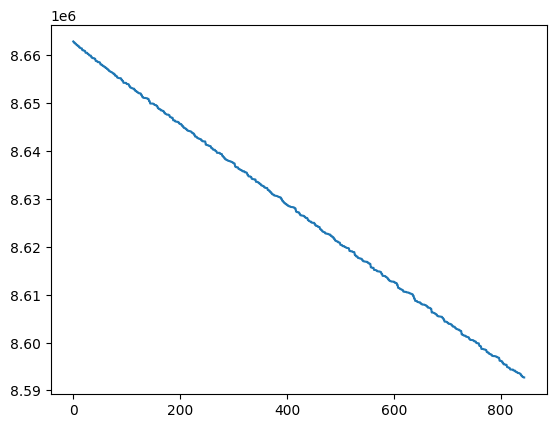

In [125]:
prop_constants = fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
print(prop_constants.shape)

degen_betas = np.zeros(shape=(fiber._N_modes_degen))
k = 0
for i in range(fiber._N_modes):
    if prop_constants[i, 2] == 0: # Mode is centro-symmetric
        degen_betas[k] = prop_constants[i, 0]
        k += 1
    else: # Mode is not centro-symmetric
        degen_betas[k] = prop_constants[i, 0]
        degen_betas[k+1] = prop_constants[i, 0]
        k += 2
        
plt.plot(degen_betas)

Now let's create the propagation matrix with no mode energy exchange, this matrix is diagonal.
Then compute the new modes coefficients. Only their phases should have changed.

In [136]:
propagation_matrix = np.diag(np.exp(-1j * degen_betas * fiber_length))
new_coeffs = propagation_matrix @ coupled_in.modes_coeffs

# The difference between new and old coeffs amplitudes should be close to 0
print(np.sum(np.abs(new_coeffs) - np.abs(coupled_in.modes_coeffs)))

2.5212651150473712e-08


In [130]:
print(new_coeffs[1:10])
print(np.sum(np.square(np.abs(new_coeffs))))

[-3.47368902e-01+2.43559366e-01j  2.89968150e-06+3.33398451e-06j
  1.30690398e-02-3.92188619e-01j -8.15323240e-06+5.80086880e-07j
  1.39637104e-01+1.08969773e-01j -2.54820153e-01-2.04074040e-01j
 -5.51239989e-06+8.58266787e-06j -9.04169522e-02+8.97070853e-02j
  1.02729814e-06+8.39265772e-07j]
0.9999974200591433


### Get the speckle at the fiber output

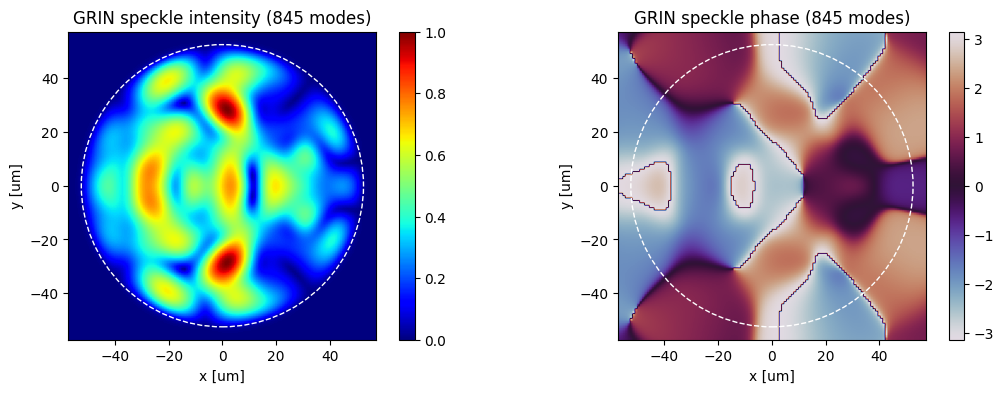

In [137]:
coupled_out = deepcopy(coupled_in)
coupled_out.modes_coeffs = new_coeffs
coupled_out.recompose()
_ = coupled_out.plot(cmap='jet', complex=True)

In [112]:
print(np.sum(np.square(np.abs(coupled_out.modes_coeffs))))

print(np.square(np.abs(coupled_out.modes_coeffs[np.square(np.abs(coupled_out.modes_coeffs)) > 1e-2])))

0.9999974798038914
[0.08274751 0.21135743 0.17829766 0.03034473 0.12169758 0.0720593
 0.01090217 0.0125965  0.03827047 0.02876408 0.01857898 0.03806375
 0.03258632 0.02319876 0.02572667 0.01627823]


### Fourier transform the output speckle after padding it

(2048, 2048)
(2048, 2048)


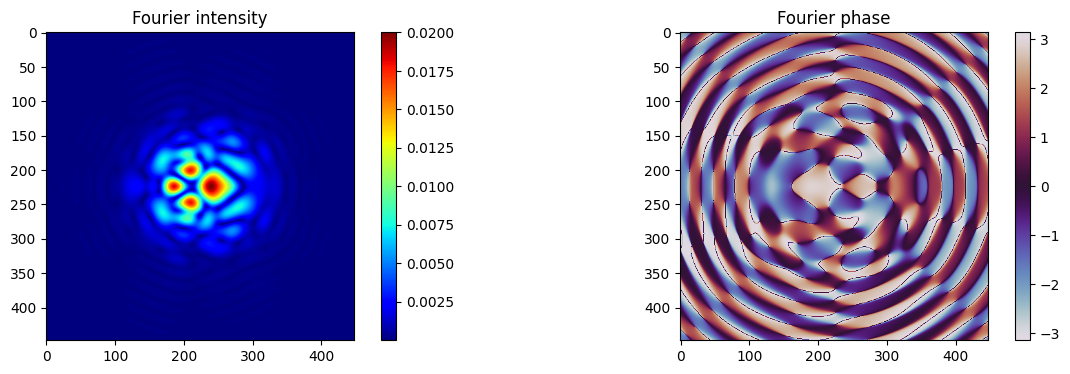

In [138]:
speckle = coupled_out.field
pad_amount = (grid_length_fourier - grid_length) // 2
padded_speckle = np.pad(speckle, pad_width=pad_amount)
print(padded_speckle.shape)

speckle_fourier = fourier_transform(padded_speckle)
print(speckle_fourier.shape)

idx_min = 800
idx_max = -800

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].set_title('Fourier intensity')
pl0 = axs[0].imshow(np.abs(speckle_fourier[idx_min:idx_max, idx_min:idx_max]), cmap='jet')
plt.colorbar(pl0, ax=axs[0])

axs[1].set_title('Fourier phase')
pl1 = axs[1].imshow(np.angle(speckle_fourier[idx_min:idx_max, idx_min:idx_max]), cmap='twilight')
plt.colorbar(pl1, ax=axs[1])

### Export for Matlab

In [107]:
mdict = {
    'input_field': beam.field,
    'prop_constants': prop_constants,
    'degen_betas': degen_betas,
    'input_coeffs': coupled_in.modes_coeffs,
    'propagation_matrix': propagation_matrix,
    'output_coeffs': coupled_out.modes_coeffs,
    'output_field': speckle,
    'padded_output_field': padded_speckle,
    'fourier_padded_output_field': speckle_fourier,
}

savemat('step_index_for_comparison.mat', mdict=mdict)